In [1]:
from os.path  import join
import struct
from array import array
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

# Set file paths based on added MNIST Datasets
training_images_filepath = '../data/mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = '../data/mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = '../data/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = '../data/mnist-dataset/t10k-labels.idx1-ubyte'

In [3]:
# Load MINST dataset
print('Loading MNIST dataset...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('MNIST dataset loaded.')

Loading MNIST dataset...
MNIST dataset loaded.


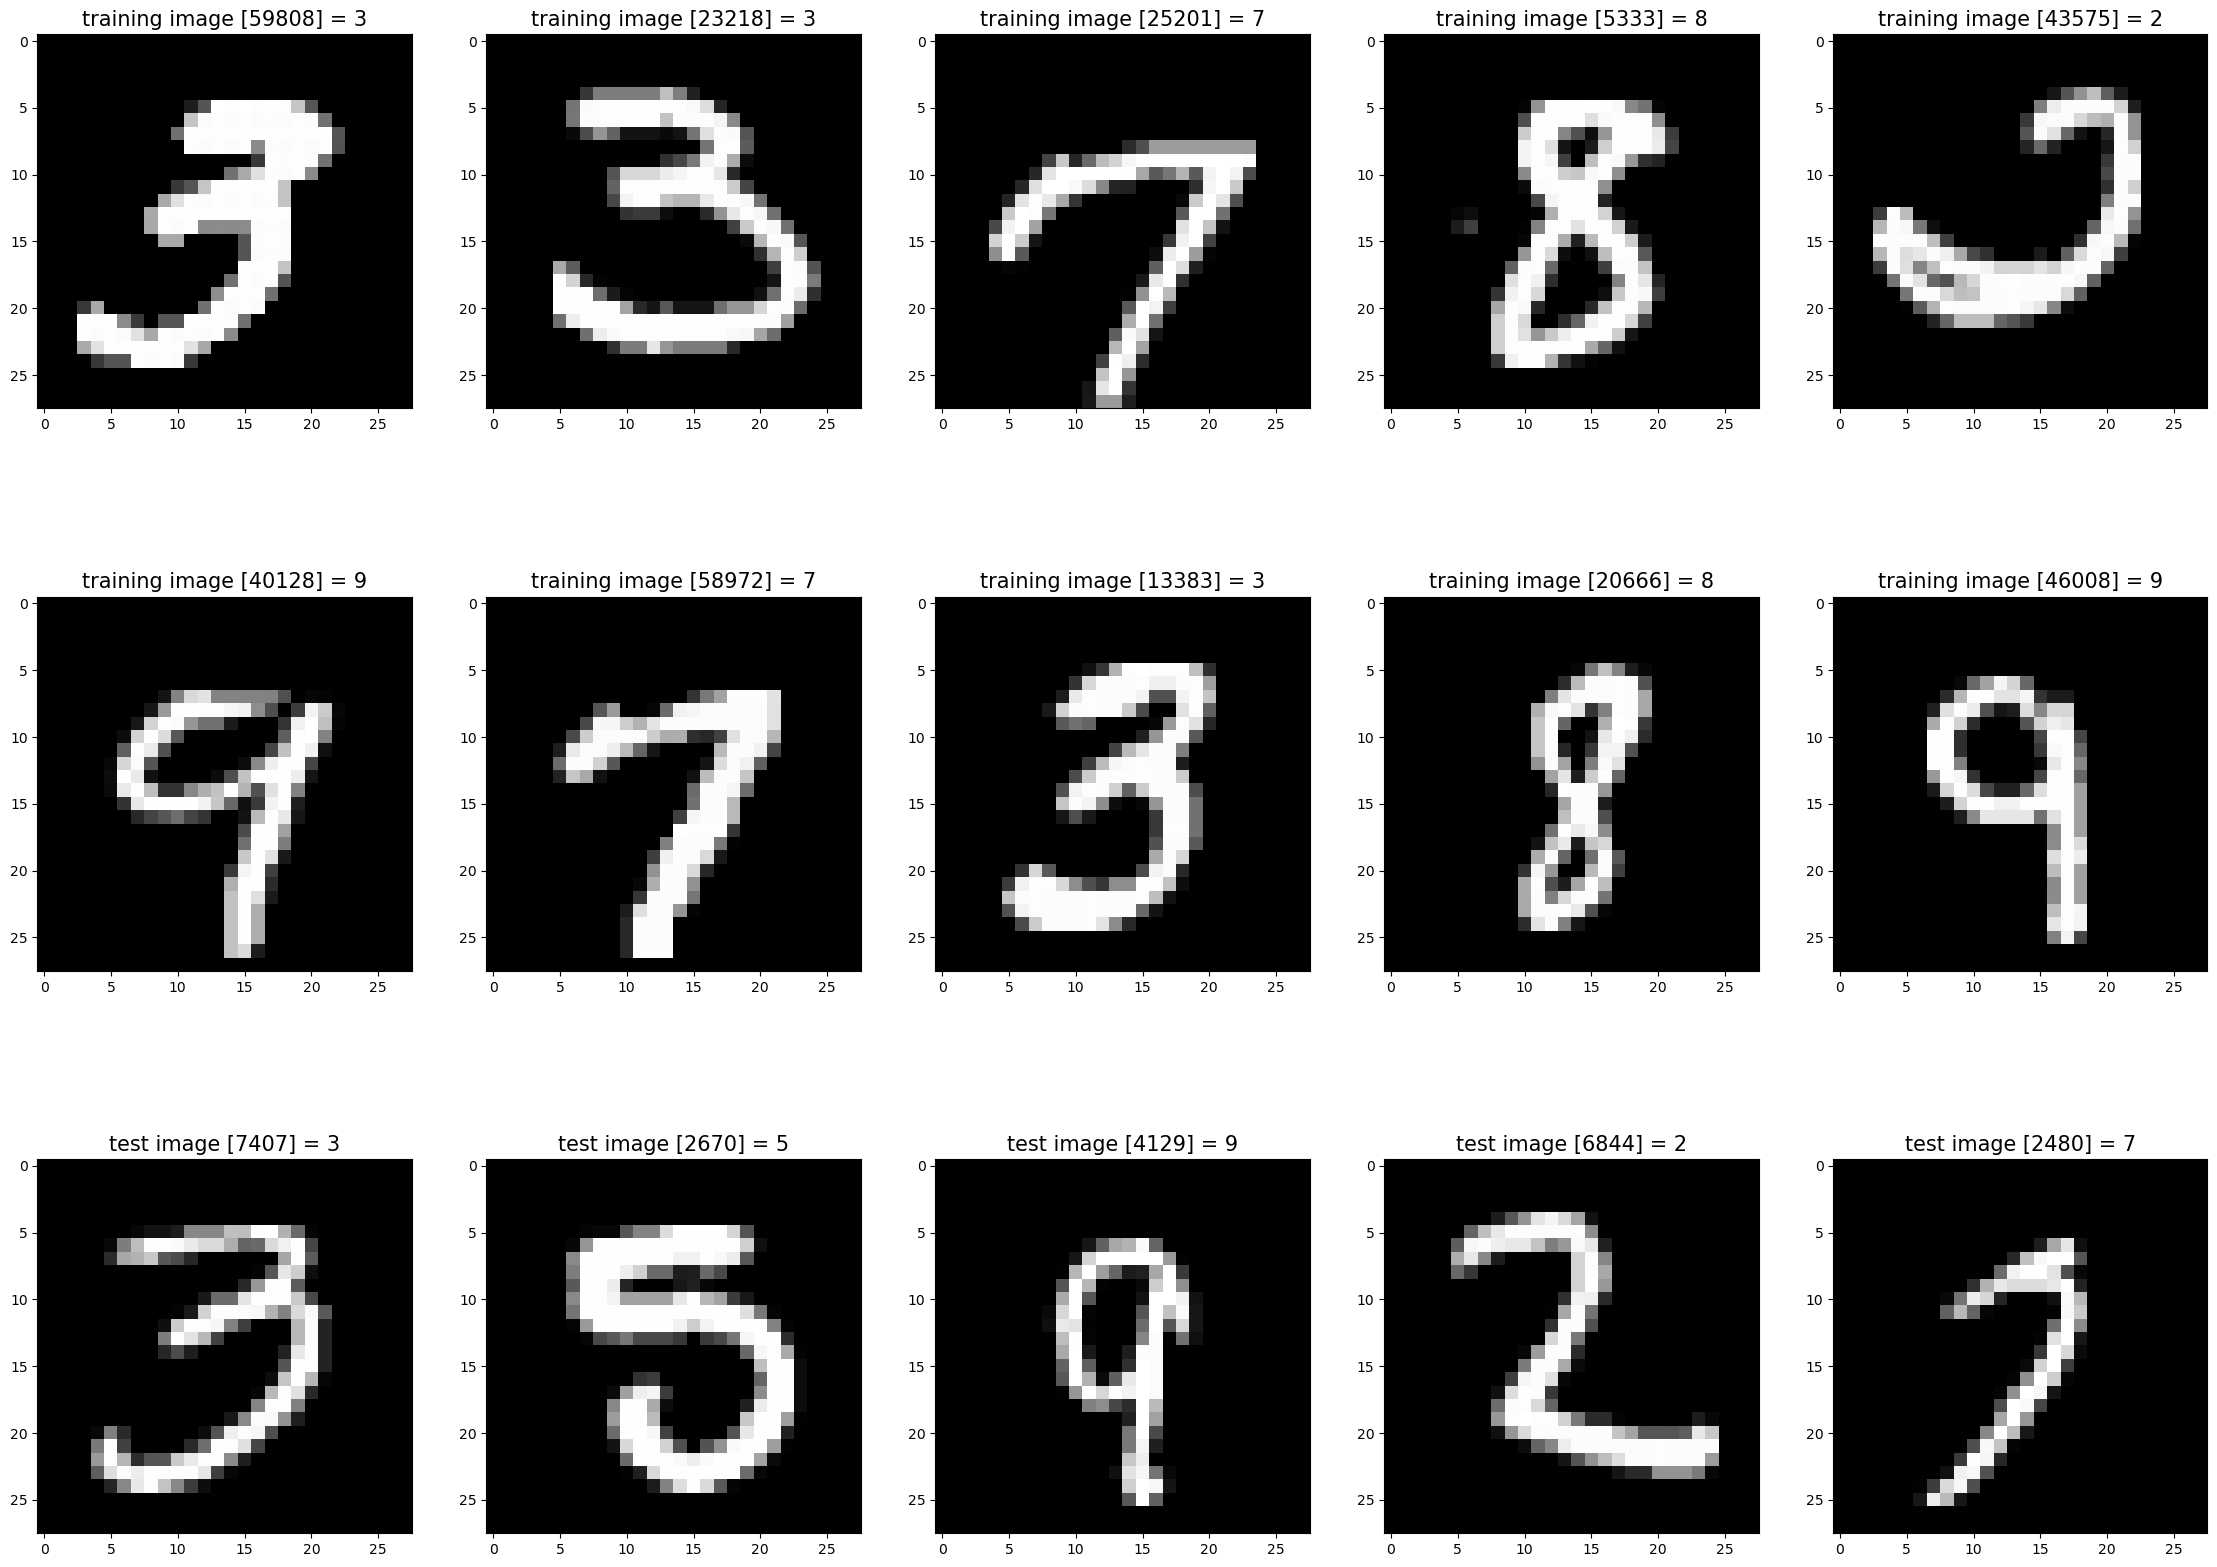

In [4]:
# Show example images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

random_images = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    random_images.append((x_train[r], 'training image [' + str(r) + '] = ' + str(y_train[r])))
for i in range(0, 5):
    r = random.randint(1, 10000)
    random_images.append((x_test[r], 'test image [' + str(r) + '] = ' + str(y_test[r])))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [6]:
# Convert data to PyTorch tensors
train_images_tensor = torch.tensor(x_train, dtype=torch.float) / 255.0  # Normalize
train_labels_tensor = torch.tensor(y_train, dtype=torch.long)
test_images_tensor = torch.tensor(x_test, dtype=torch.float) / 255.0  # Normalize
test_labels_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images_tensor.unsqueeze(1), train_labels_tensor)  # Add channel dimension
test_dataset = TensorDataset(test_images_tensor.unsqueeze(1), test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/var/folders/wp/7bp3qrzx7dx95tf0806th2rw0000gn/T/ipykernel_15773/3580126132.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/torch/csrc/utils/tensor_new.cpp:204.)
  train_images_tensor = torch.tensor(x_train, dtype=torch.float) / 255.0  # Normalize


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming train_loader and test_loader are defined elsewhere

# Define a simple MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)  # 10 classes for MNIST digits
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(10):  # train for 10 epochs
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the test images: {accuracy * 100:.2f}%')

Accuracy of the model on the test images: 94.04%


In [8]:
x_train = np.array(x_train)
x_test = np.array(x_test)

X_train_flat = x_train.reshape(x_train.shape[0], -1)
X_test_flat = x_test.reshape(x_test.shape[0], -1)

y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Normalize the features to [0, 1]
X_train_flat = X_train_flat / 255.0
X_test_flat = X_test_flat / 255.0

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
clf = SVC(kernel='linear', C=1.0)

# Train the classifier
clf.fit(X_train_flat, y_train_np)

# Make predictions on the test set
y_pred = clf.predict(X_test_flat)

# Calculate the accuracy
accuracy = accuracy_score(y_test_np, y_pred)
print(f'Accuracy of the SVM on the test images: {accuracy * 100:.2f}%')

Accuracy of the SVM on the test images: 94.04%


### (b) Modify the code to train the same model with the test data, and evaluate the accuracy using the training data. What is your accuracy?

In [10]:
# Define a simple MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)  # 10 classes for MNIST digits
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(10):  # train for 10 epochs
    for images, labels in test_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the train images: {accuracy * 100:.2f}%')

Accuracy of the model on the train images: 86.78%


### (c) Consider the following modification of the data set: for every hand written digit image, suppose the corresponding digit is $i \in \{0, . . . , 9\}$, change its label $(y)$ to $i \% 2$ (i.e., mod $(i, 2)$).

* item Show me your code that modifies y\_train and y\_test to align with the data set modifications.  

In [11]:
# Calculating mod
y_train_mod = np.mod(y_train, 2)
y_test_mod = np.mod(y_test, 2)

# Tranforming it into tensor dataset
y_train_mod_tensor = torch.tensor(y_train_mod, dtype=int)
y_test_mod_tensor = torch.tensor(y_test_mod, dtype=int)

# Create TensorDatasets
train_dataset_mod = TensorDataset(train_images_tensor.unsqueeze(1), y_train_mod_tensor)  # Add channel dimension
test_dataset_mod = TensorDataset(test_images_tensor.unsqueeze(1), y_test_mod_tensor)

# Create DataLoaders
train_loader_mod = DataLoader(train_dataset_mod, batch_size=64, shuffle=True)
test_loader_mod = DataLoader(test_dataset_mod, batch_size=64, shuffle=False)

* Using the same MLP provided in the “MNIST.ipynb", what minimum change should you make to have the model work with the modified data set (i.e., what is your number of outputs)?

In [22]:
# Define a simple MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 2)  # 2 classes for mod labels
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(10):  # train for 10 epochs
    for images, labels in train_loader_mod:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_mod:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the train images: {accuracy * 100:.2f}%')

Accuracy of the model on the train images: 97.69%


The changes are:
* Update the tensor dataset with the new lables.
* Update the output units to 2 (0, 1).

The number of outputs is 2 (0, 1)

* What are the one hot encoded outcomes of the labels in the modified data set?\
The one hot encoded outcomes are 0: [1,0] and 1: [0,1]

### (d) Modify your train data set such that there are only 10 images left with the label being 3, and 10 images left with the label being 9.

* Show me your code that makes the above modification.

In [13]:
y_train_np = np.array(y_train)
x_train_np = np.array(x_train)
label_3_index = np.where(y_train_np == 3)[0][0:10]
label_9_index = np.where(y_train_np == 9)[0][0:10]

In [14]:
x_train_3_9 = np.concatenate((x_train_np[label_3_index], x_train_np[label_9_index]), axis=0)
x_train_3_9.shape

(20, 28, 28)

In [15]:
y_train_3_9 = np.concatenate((y_train_np[label_3_index], y_train_np[label_9_index]), axis=0)
y_train_3_9.shape

(20,)

In [16]:
# Convert data to PyTorch tensors
train_images_tensor_3_9 = torch.tensor(x_train_3_9, dtype=torch.float) / 255.0  # Normalize
train_labels_tensor_3_9 = torch.tensor(y_train_3_9, dtype=torch.long)

# Create TensorDatasets
train_dataset_3_9 = TensorDataset(train_images_tensor_3_9.unsqueeze(1), train_labels_tensor_3_9)  # Add channel dimension

# Create DataLoaders
train_loader_3_9 = DataLoader(train_dataset_3_9, batch_size=64, shuffle=True)

* Using the same MLP provided in the “MNIST.ipynb", and train the model with the modified data set. Evaluate your model’s performance with the testing data set. Your model should be performing worse than the original model. Describe what changes you could make to improve the model’s performance given the modified data set? Undoing your above data set modifications cannot be a solution. Do not include your code, but you are welcome to use experiments or other analyses to help deriving your answer to this question.

In [17]:
# Define a simple MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)  # 10 classes for MNIST digits
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(10):  # train for 10 epochs
    for images, labels in train_loader_3_9:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the test images: {accuracy * 100:.2f}%')

Accuracy of the model on the test images: 15.53%


In order to improve the model's performance given the modified, we could:
* Perform the same data modification on the test dataset. Then change the output layer to a binary classification instead of 10.
* Decrease model complexity. By doing this, the model would be able to generalize more.

In [18]:
# Define a simple MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 212),
    nn.ReLU(),
    nn.Linear(212, 10)  # 10 classes for MNIST digits
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(10):  # train for 10 epochs
    for images, labels in train_loader_3_9:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the test images: {accuracy * 100:.2f}%')

Accuracy of the model on the test images: 10.57%
